<a href="https://colab.research.google.com/github/tushar-marine/colon_cancer/blob/main/fusion_model_VGG19_ResNet50V2_colon_cancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Adding Google Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##**Moving to working directory** 

In [ ]:
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/thesis')

#**Importing required libraries**

In [ ]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from scipy import misc

#**Data Preprocessing**

##**Loading the data**

In [ ]:
data_path = "/content/drive/MyDrive/Colab Notebooks/thesis/dataset/"
num_classes = 8

x = []
y = []
for category in os.listdir(data_path):
    for image in os.listdir(data_path + category):
        if image.endswith(".tif"):
            arr = cv2.imread(data_path + category + '/' + image)
            x.append(arr)
            y.append(category)

In [ ]:
class_names = ['tumor', 'stroma', 'complex', 'lympho', 'debris', 'mucosa', 'adipose', 'empty']

##**Encoding data into a numerical representation**##

In [ ]:
input_shape = (150, 150, 3)
encoder = LabelEncoder()
encoder.fit(y)
encoded_y = encoder.transform(y)
y = keras.utils.to_categorical(encoded_y, num_classes)

##**Shuffling the data**##

In [ ]:
x, y = shuffle(x, y, random_state=1)

##**Splitting the dataset for trainng and testing**##

In [ ]:
# 90% for training and 10% for testing
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.1,random_state=42)

##**Normalisation by scaling all pixel intensities**##

In [ ]:
x_train = np.array(x_train, dtype=np.float32)
x_test = np.array(x_test, dtype=np.float32)
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (4500, 150, 150, 3)
4500 train samples
500 test samples


#**Building models**

##**Model-1**

In [ ]:
from tensorflow.keras.applications import ResNet50V2

model_1 = ResNet50V2(weights="imagenet", input_shape=input_shape, include_top=False)

# Freeze the first 20 layers
for layer in model_1.layers[:20]:
    layer.trainable = False

# Adding Global Average Pooling (GAP) layer to the Xception
x_model_1 = model_1.output
x_model_1 = tf.keras.layers.GlobalAveragePooling2D()(x_model_1)

94668760/94668760 [==============================] - 1s 0us/step


In [ ]:
len(model_1.layers)

190

##**Model-2**

In [ ]:
from tensorflow.keras.applications import VGG19

model_2 = VGG19(weights="imagenet", input_shape=input_shape, include_top=False)

# Freeze all layers
model_2.trainable = False

# Adding Global Average Pooling (GAP) layer to the ResNet50V2
x_model_2 = model_2.output
x_model_2 = tf.keras.layers.GlobalAveragePooling2D()(x_model_2)

80134624/80134624 [==============================] - 0s 0us/step


In [ ]:
len(model_2.layers)

22

##**Fusion Model**##

In [ ]:
# concatenation of Model-1 & Model-2
x_combined = tf.keras.layers.concatenate([x_model_2, x_model_1])

# Adding dropout (for regularization), SoftMax, Adam as optimizer and categorical_crossentropy as loss function
x_combined = tf.keras.layers.Dense(256, activation="relu")(x_combined)
x_combined = tf.keras.layers.Dropout(0.6)(x_combined)
predictions = tf.keras.layers.Dense(8, activation="softmax")(x_combined)   
fusion_model = tf.keras.models.Model( inputs = [model_1.input, model_2.input] , outputs = predictions)
fusion_model.compile(loss = "categorical_crossentropy",
                     optimizer = tf.keras.optimizers.Adam(),
                     metrics = ["accuracy"])

In [ ]:
history_record = fusion_model.fit(x=[x_train, x_train], y = y_train, 
                           batch_size=32,
                           epochs=12, 
                           verbose=1,
                           validation_data=([x_test, x_test], y_test))

Epoch 1/12
141/141 [==============================] - 2646s 19s/step - loss: 0.8685 - accuracy: 0.7191 - val_loss: 19.0334 - val_accuracy: 0.2020
Epoch 2/12
141/141 [==============================] - 2622s 19s/step - loss: 0.4810 - accuracy: 0.8471 - val_loss: 13.8828 - val_accuracy: 0.7400
Epoch 3/12
141/141 [==============================] - 2634s 19s/step - loss: 0.4321 - accuracy: 0.8600 - val_loss: 0.6487 - val_accuracy: 0.7680
Epoch 4/12
141/141 [==============================] - 2628s 19s/step - loss: 0.3653 - accuracy: 0.8816 - val_loss: 0.3715 - val_accuracy: 0.8720
Epoch 5/12
141/141 [==============================] - 2627s 19s/step - loss: 0.3267 - accuracy: 0.8929 - val_loss: 2.0277 - val_accuracy: 0.6760
Epoch 6/12
141/141 [==============================] - 2629s 19s/step - loss: 0.3110 - accuracy: 0.8938 - val_loss: 0.8077 - val_accuracy: 0.8320
Epoch 7/12
141/141 [==============================] - 2637s 19s/step - loss: 0.2533 - accuracy: 0.9162 - val_loss: 0.9982 - val_

##**Fine-tuning Model**##

In [ ]:
# Unfreeze the entire base model
model_1.trainable = True
model_2.trainable = True

# Freeze all layers except the last 10 layers for both models
for layer in model_2.layers[:-10]:
  layer.trainable = False

for layer in model_2.layers[:-10]:
  layer.trainable = False

In [ ]:
fusion_model.compile(loss = "categorical_crossentropy",
                     optimizer = tf.keras.optimizers.Adam(0.00001),
                     metrics = ["accuracy"])
history_fine_tuning = fusion_model.fit(x=[x_train, x_train], y = y_train, 
                           batch_size=32,
                           epochs=12, 
                           verbose=1,
                           validation_data=([x_test, x_test], y_test))

Epoch 1/12
141/141 [==============================] - 4111s 29s/step - loss: 0.1656 - accuracy: 0.9498 - val_loss: 0.8368 - val_accuracy: 0.8060
Epoch 2/12
141/141 [==============================] - 4073s 29s/step - loss: 0.0992 - accuracy: 0.9682 - val_loss: 0.3552 - val_accuracy: 0.9100
Epoch 3/12
141/141 [==============================] - 4089s 29s/step - loss: 0.0714 - accuracy: 0.9773 - val_loss: 0.3037 - val_accuracy: 0.9220
Epoch 4/12
141/141 [==============================] - 4071s 29s/step - loss: 0.0586 - accuracy: 0.9838 - val_loss: 0.2781 - val_accuracy: 0.9220
Epoch 5/12
141/141 [==============================] - 4089s 29s/step - loss: 0.0663 - accuracy: 0.9789 - val_loss: 0.2652 - val_accuracy: 0.9260
Epoch 6/12
141/141 [==============================] - 4134s 29s/step - loss: 0.0498 - accuracy: 0.9869 - val_loss: 0.3211 - val_accuracy: 0.9160
Epoch 7/12
141/141 [==============================] - 4143s 29s/step - loss: 0.0454 - accuracy: 0.9887 - val_loss: 0.2588 - val_ac

# **Testing the Model**

**Model plotting with details by layers**

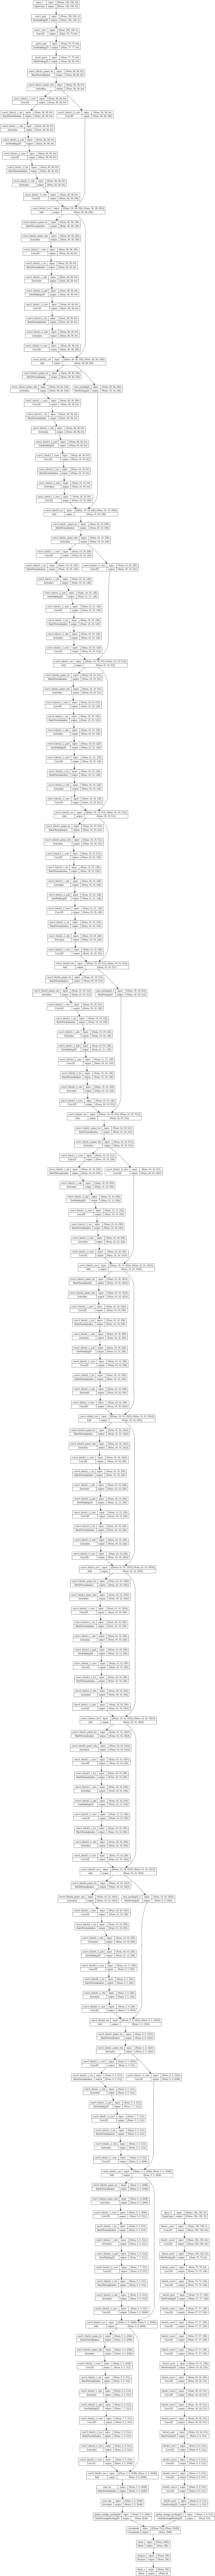

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(fusion_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

**Test Score**

In [ ]:
test_score = fusion_model.evaluate(x=[x_test, x_test], y = y_test, verbose=0)
print('Test loss:', test_score[0])
print('Test accuracy:', test_score[1])

Test loss: 0.26994383335113525
Test accuracy: 0.9279999732971191


**Model Accuracy Curve** 

In [ ]:
loss_fn = history_record.history['loss']
val_loss_fn = history_record.history['val_loss']
accuracy_fn = history_record.history['accuracy']
val_accuracy_fn = history_record.history['val_accuracy']
epochs = range(len(history_record.history['loss']))

loss_tuned = history_fine_tuning.history['loss']
val_loss_tuned = history_fine_tuning.history['val_loss']
accuracy_tuned = history_fine_tuning.history['accuracy']
val_accuracy_tuned = history_fine_tuning.history['val_accuracy']

# Plotting accuracy curve
plt.figure()
plt.plot(epochs, accuracy_fn, label='Training Accuracy - feature extraction')
plt.plot(epochs, val_accuracy_fn, label='Testing Accuracy - feature extraction')
plt.plot(epochs, accuracy_tuned, label='Training Accuracy - fine-tuning')
plt.plot(epochs, val_accuracy_tuned, label='Testing Accuracy - fine-tuning')
plt.title('Accuracy of Fusion Model')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend();

**Model Loss Curve**

In [ ]:
# Plotting loss curve
plt.figure()
plt.plot(epochs, loss_fn, label='training loss - feature extraction')
plt.plot(epochs, val_loss_fn, label='testing loss - feature extraction')
plt.plot(epochs, loss_tuned, label='training loss - fine-tuning')
plt.plot(epochs, val_loss_tuned, label='testing loss - fine-tuning')
plt.title('Loss Curve of Fusion Model')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend();

**Confusion Matrix**

In [ ]:
# Model prediction for test data
pred = fusion_model.predict(x=[x_test, x_test])

# Match the prediction class to the highest prediction probability
y_pred = [pred[i].argmax() for i in range(len(pred))]
y_pred_class = [class_names[y_pred[i]] for i in range(len(y_pred))]

# Extract the truth ground label and match to class_names 
y_true = []
for i in range(len(y_test)):
    for y in range(8):
        if y_test[i][y]==1:
            y_true.append(y)
            break

y_true_class = [class_names[y_true[i]] for i in range(len(y_true))]

16/16 [==============================] - 172s 11s/step


In [ ]:
# Plotting confusion matrix
cm = confusion_matrix(y_true=y_true, y_pred=y_pred)
plt.figure(figsize=(10,8))
ax = sns.heatmap(cm/np.sum(cm),fmt='.2%', annot=True, cmap='YlOrRd')
ax.set_title('Confusion Matrix\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
ax.xaxis.set_ticklabels(class_names)
ax.yaxis.set_ticklabels(class_names)
plt.show()

**Classification Report**

In [ ]:
print(classification_report(y_true_class, y_pred_class, digits=3))

              precision    recall  f1-score   support

     adipose      0.857     0.909     0.882        66
     complex      0.907     0.919     0.913        74
      debris      0.982     0.917     0.948        60
       empty      0.980     0.926     0.952        54
      lympho      0.967     1.000     0.983        59
      mucosa      1.000     0.969     0.984        64
      stroma      0.774     0.857     0.814        56
       tumor      0.984     0.925     0.954        67

    accuracy                          0.928       500
   macro avg      0.931     0.928     0.929       500
weighted avg      0.932     0.928     0.929       500

              precision    recall  f1-score   support

     adipose      0.857     0.909     0.882        66
     complex      0.907     0.919     0.913        74
      debris      0.982     0.917     0.948        60
       empty      0.980     0.926     0.952        54
      lympho      0.967     1.000     0.983        59
      mucosa      1.000 

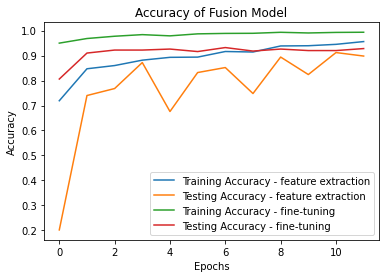

In [ ]:
loss_fn = history_record.history['loss']
val_loss_fn = history_record.history['val_loss']
accuracy_fn = history_record.history['accuracy']
val_accuracy_fn = history_record.history['val_accuracy']
epochs = range(len(history_record.history['loss']))

loss_tuned = history_fine_tuning.history['loss']
val_loss_tuned = history_fine_tuning.history['val_loss']
accuracy_tuned = history_fine_tuning.history['accuracy']
val_accuracy_tuned = history_fine_tuning.history['val_accuracy']

# Plotting accuracy curve
plt.figure()
plt.plot(epochs, accuracy_fn, label='Training Accuracy - feature extraction')
plt.plot(epochs, val_accuracy_fn, label='Testing Accuracy - feature extraction')
plt.plot(epochs, accuracy_tuned, label='Training Accuracy - fine-tuning')
plt.plot(epochs, val_accuracy_tuned, label='Testing Accuracy - fine-tuning')
plt.title('Accuracy of Fusion Model')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend();

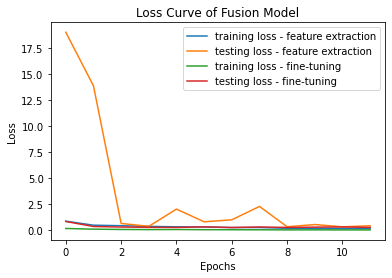

In [ ]:
# Plotting loss curve
plt.figure()
plt.plot(epochs, loss_fn, label='training loss - feature extraction')
plt.plot(epochs, val_loss_fn, label='testing loss - feature extraction')
plt.plot(epochs, loss_tuned, label='training loss - fine-tuning')
plt.plot(epochs, val_loss_tuned, label='testing loss - fine-tuning')
plt.title('Loss Curve of Fusion Model')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend();

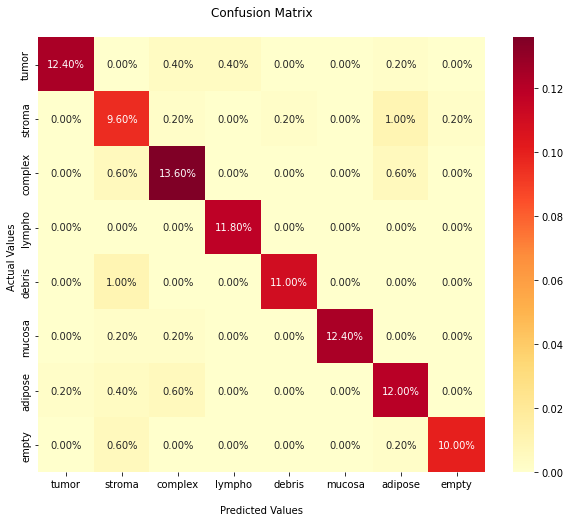

In [ ]:
# Plotting confusion matrix
cm = confusion_matrix(y_true=y_true, y_pred=y_pred)
plt.figure(figsize=(10,8))
ax = sns.heatmap(cm/np.sum(cm),fmt='.2%', annot=True, cmap='YlOrRd')
ax.set_title('Confusion Matrix\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
ax.xaxis.set_ticklabels(class_names)
ax.yaxis.set_ticklabels(class_names)
plt.show()